In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import os
# from identity_estimator import IdentityEstimator

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, brier_score_loss

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

class IdentityEstimator(BaseEstimator, ClassifierMixin):
    '''
    An identity estimator used for calibrating probability data
    '''
 
    def __init__(self):
        self.classes_= [0, 1]
        # pass
       
 
    def __getstate__(self):
        # Copy the object's state from self.__dict__ which contains
        # all our instance attributes. Always use the dict.copy()
        # method to avoid modifying the original state.
        state = self.__dict__.copy()
 
        return state
 
    def __setstate__(self, state):
        # Restore instance attributes
        self.__dict__.update(state)
        
 
    def fit(self, X, y, sample_weight=None):
        return self
 
    def predict_proba(self, X):
        
        assert X.shape[1] == 1
        probs = np.concatenate((1 - X, X), axis=1)
        return probs

#### Example of how Identity estimator works:

In [5]:
# generate 10 random probabilities 
a = np.random.random(10)
a

array([0.6615945 , 0.56417737, 0.0274456 , 0.01944355, 0.17109991,
       0.71871128, 0.04191404, 0.1508992 , 0.95856249, 0.96123389])

In [6]:
# reshape them to be size (10, 1)
X = np.reshape(a, (-1, 1))
X

array([[0.6615945 ],
       [0.56417737],
       [0.0274456 ],
       [0.01944355],
       [0.17109991],
       [0.71871128],
       [0.04191404],
       [0.1508992 ],
       [0.95856249],
       [0.96123389]])

In [7]:
# an identity estimator will output the same probs as a 2d array (prob_0, prob_1):
model = IdentityEstimator()
probs = model.predict_proba(X)
print(probs)

[[0.3384055  0.6615945 ]
 [0.43582263 0.56417737]
 [0.9725544  0.0274456 ]
 [0.98055645 0.01944355]
 [0.82890009 0.17109991]
 [0.28128872 0.71871128]
 [0.95808596 0.04191404]
 [0.8491008  0.1508992 ]
 [0.04143751 0.95856249]
 [0.03876611 0.96123389]]


#### load prediction files

In [5]:
train_path = 'multi_head_subtypes_+pretrain_+seg_plus_clinical__train_last_epochlesion_data.csv'
val_path = 'multi_head_subtypes_+pretrain_+seg_plus_clinical__validation_last_epochlesion_data.csv'
ho_path = 'multi_head_subtypes_+pretrain_+seg_plus_clinical__heldout_last_epochlesion_data.csv'

train = pd.read_csv(train_path, index_col = 0)
val = pd.read_csv(val_path, index_col = 0)
ho = pd.read_csv(ho_path, index_col = 0)

In [6]:
train.head()

,viewpoint,xml_url,finding_id,image_id,study_id,pathology,provider,side,type,patient_id,...,pred_classA,is_classA,pred_classB,is_classB,pred_classC,is_classC,pred_classD,is_classD,pred_classE,is_classE
0,MLO,/gpfs/haifa/projects/m/msieve/MedicalSieve/Pat...,T1,1.2.840.113681.2216859374.947.3552550853.521.1,1979559,Fibroadenoma,miami,left,Tumor,966279573089,...,0.000887,False,0.000041,False,0.006413,False,0.076159,False,0.988652,True
1,CC,/gpfs/haifa/projects/m/msieve/MedicalSieve/Pat...,T1,1.2.840.113681.2216859374.947.3552550853.523.1,1979559,Fibroadenoma,miami,left,Tumor,966279573089,...,0.001267,False,0.728517,False,0.003379,False,0.023614,False,0.057535,True
2,MLO,/gpfs/haifa/projects/m/msieve/MedicalSieve/Pat...,T2,1.2.840.113681.2216859374.964.3543825240.343.1,1941062,Fibroadenoma,miami,right,Tumor,950786925525,...,0.000020,False,0.000032,False,0.005593,False,0.000854,False,0.997824,True
3,MLO,/gpfs/haifa/projects/m/msieve/MedicalSieve/Pat...,T2,1.2.840.113681.2216859374.964.3543825240.343.1,1941062,Fibroadenoma,miami,right,Tumor,950786925525,...,0.000155,False,0.000642,False,0.002464,False,0.001464,False,0.991388,True
4,MLO,/gpfs/haifa/projects/m/msieve/MedicalSieve/Pat...,T1,1.2.840.113681.2216859374.964.3543825240.343.1,1941062,IntramammaryLymphNode,miami,right,Tumor,950786925525,...,0.000020,False,0.000032,False,0.005593,False,0.000854,False,0.997824,True


#### create X and y dataframes: X are just prediction columns, y are the output classes

In [7]:
classes = [x for x in train if 'is_class' in x]
preds = [x for x in train if 'pred' in x]

x_train = train[preds]
x_val = val[preds]
x_ho = ho[preds]

y_train = train[classes].astype(int)
y_val = val[classes].astype(int)
y_ho = ho[classes].astype(int)

In [8]:
classes

['is_classA', 'is_classB', 'is_classC', 'is_classD', 'is_classE']

In [9]:
x_train.head()

,pred_classA,pred_classB,pred_classC,pred_classD,pred_classE
0,0.000887,0.000041,0.006413,0.076159,0.988652
1,0.001267,0.728517,0.003379,0.023614,0.057535
2,0.000020,0.000032,0.005593,0.000854,0.997824
3,0.000155,0.000642,0.002464,0.001464,0.991388
4,0.000020,0.000032,0.005593,0.000854,0.997824


In [10]:
y_train.head()

,is_classA,is_classB,is_classC,is_classD,is_classE
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


### Heldout set:  check calibration plots (uncalibrated)

**is_classA ...**
	Brier: 0.094
	Accuracy: 0.883
	F1: 0.324
**is_classB ...**
	Brier: 0.156
	Accuracy: 0.807
	F1: 0.614
**is_classC ...**
	Brier: 0.050
	Accuracy: 0.947
	F1: 0.000
**is_classD ...**
	Brier: 0.068
	Accuracy: 0.929
	F1: 0.000
**is_classE ...**
	Brier: 0.215
	Accuracy: 0.718
	F1: 0.750


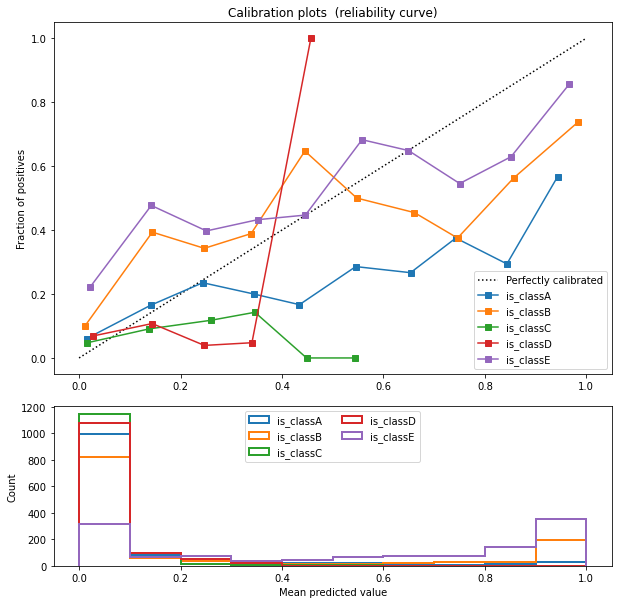

In [11]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

        
for i, category in enumerate(classes):
    
    print('**{} ...**'.format(category))

    prob_pos = x_ho.iloc[:, i]
    y_pred = np.rint(x_ho.iloc[:, i])
    y_true = y_ho[category]

    clf_score = brier_score_loss(y_true, prob_pos, pos_label=1)
    print("\tBrier: %1.3f" % (clf_score))
    print("\tAccuracy: %1.3f" % accuracy_score(y_true, y_pred))
    print("\tF1: %1.3f" % f1_score(y_true, y_pred))

    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label= category)
    ax2.hist(prob_pos, range=(0, 1), bins=10, label=category, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


plt.show()

### Using Calibration CV

**is_classA ...**
	Brier: 0.097
	Precision: 0.425
	Recall: 0.248
	F1: 0.313
**is_classB ...**
	Brier: 0.169
	Precision: 0.653
	Recall: 0.575
	F1: 0.611
**is_classC ...**
	Brier: 0.054
	Precision: 0.077
	Recall: 0.016
	F1: 0.026
**is_classD ...**
	Brier: 0.082
	Precision: 0.053
	Recall: 0.023
	F1: 0.032
**is_classE ...**
	Brier: 0.217
	Precision: 0.739
	Recall: 0.762
	F1: 0.750


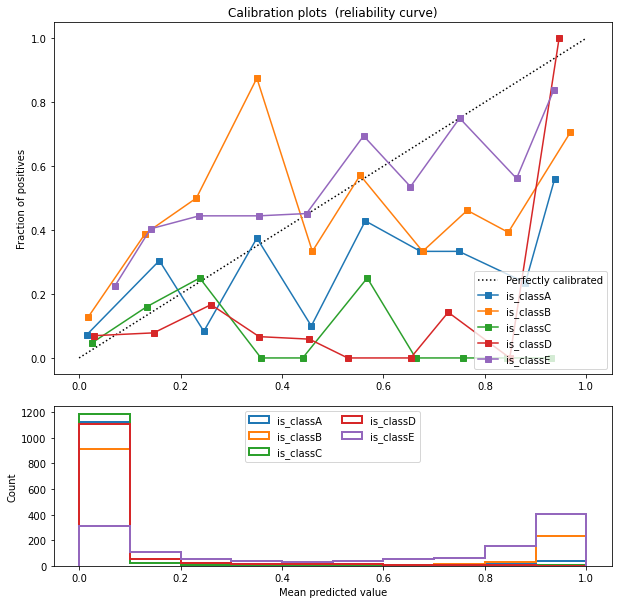

In [12]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_all = []

for i, category in enumerate(classes):

    print('**{} ...**'.format(category))        
    
    calibrated = CalibratedClassifierCV(base_estimator = IdentityEstimator(),
                                        method = 'sigmoid', cv = 3)
        
    x_trainval = pd.concat([x_train, x_val]).reset_index(drop=True)
    y_trainval = pd.concat([y_train, y_val]).reset_index(drop=True)

    calibrated.fit(np.reshape(x_trainval.iloc[:, i].values, (-1, 1)), y_trainval[category].values)

    y_pred = calibrated.predict(np.reshape(x_ho.iloc[:, i].values, (-1, 1)))
    prob_pos = calibrated.predict_proba(np.reshape(x_ho.iloc[:, i].values, (-1, 1)))[:, 1]

    prob_all.append(np.reshape(prob_pos, (-1, 1)))

    y_true = y_ho[category].values
    
    clf_score = brier_score_loss(y_true, prob_pos, pos_label=1)
        
    fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_true, prob_pos, n_bins=10)
        
    print("\tBrier: %1.3f" % (clf_score))
    print("\tPrecision: %1.3f" % precision_score(y_true, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_true, y_pred))
    print("\tF1: %1.3f" % f1_score(y_true, y_pred))


    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label= category)

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=category, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.show()